$\textbf{x}\in\Omega$

$$\nabla\cdot\textbf{u} = 0$$
$$\textbf{u} = -\frac{\mathsf{K}}{\mu}\cdot\nabla p$$

$\textbf{x}\in\partial\Omega_E$ essential boundary condition

$$\textbf{n}\cdot\textbf{u} = u_E$$

$\textbf{x}\in\partial\Omega_N=\partial\Omega/\partial\Omega_E$ natural boundary condition

$$p = p_N$$

In [1]:
from ufl.core.expr import Expr
from ufl import Form, dx, TestFunctions, TrialFunctions, FacetNormal, inner, inv, div

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, BoundaryConditions, OptionsPETSc
from lucifex.utils import is_tensor, fem_function_components
from lucifex.viz import plot_colormap, plot_streamlines


def darcy(
    u_p: Function,
    k: Function | Constant | Expr,
    p_bcs: BoundaryConditions | None = None,
) -> list[Form]:
    v, q = TestFunctions(u_p.function_space)
    u, p = TrialFunctions(u_p.function_space)
    n = FacetNormal(u_p.function_space.mesh)
    
    F_div = q * div(u) * dx
    if is_tensor(k):
        F_velocity = inner(v, inv(k) * u) * dx
    else:
        F_velocity = inner(v, u / k) * dx
    F_pressure = -p * div(v) * dx

    forms = [F_div, F_velocity, F_pressure]

    if p_bcs is not None:
        ds, p_natural =  p_bcs.boundary_data(u_p.function_space, 'natural')
        F_bcs = sum([inner(v, n) * pN * ds(i) for pN, i in p_natural])
        forms.append(F_bcs)

    return forms


$$\Omega = [0, L_x] \times [0, L_y]$$

$$\mathsf{K}=K(\textbf{x})\mathsf{I}$$

$$K(\textbf{x})=\begin{cases}
k_{\ell} & \textbf{x} \in \Omega_{\ell}\subset\Omega\\
1 & \text{otherwise}\\
\end{cases}
$$

$\textbf{x} \in\{(x, y)~:~0\leq x\leq L_x,~y=0\}\cup\{(x, y)~:~0\leq x\leq L_x,~y=L_y\}=\partial\Omega_E$

$$\textbf{n}\cdot\textbf{u}=0$$

$\textbf{x} \in\{(x, y)~:~x=0,~0\leq y\leq L_y\}\subset\partial\Omega_N$

$$p=1$$

$\textbf{x} \in\{(x, y)~:~x=L_x,~0\leq y\leq L_y\}\subset\partial\Omega_N$

$$p=0$$

In [2]:
Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 100, 50, cell='right')
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)

k_lens = 0.1
c = (0.5 * Lx, 0.5 * Ly)
r = (0.2 * Lx, 0.2 * Ly)
kx = lambda x: 1 + (k_lens - 1) * ((x[0] - c[0])**2 / r[0]**2 + (x[1] - c[1])**2 / r[1]**2 < 1)
k = Function((mesh, 'DP', 0), kx, name='k')

u_deg = 1
u_elem = ('BDM', u_deg)
p_elem = ('DP', u_deg - 1)
u_p_elem = [u_elem, p_elem]
u_p = Function((mesh, u_p_elem), name="up")

u_bcs = BoundaryConditions(
    ('essential', boundary['upper', 'lower'], (0.0, 0.0), 0),
)
p_bcs = BoundaryConditions(
    ('natural', boundary['left'], 1.0, 1),
    ('natural', boundary['right'], 0.0, 1),
)

petsc = OptionsPETSc.default
petsc['pc_factor_mat_solver_type'] = 'mumps'
up_solver = bvp_solver(darcy, u_bcs, petsc)(u_p, k, p_bcs)
up_solver.solve()

u, p = u_p.split(('u', 'p'), collapse=True)
ux, uy = fem_function_components(('P', 1), u, names=('ux', 'uy'))

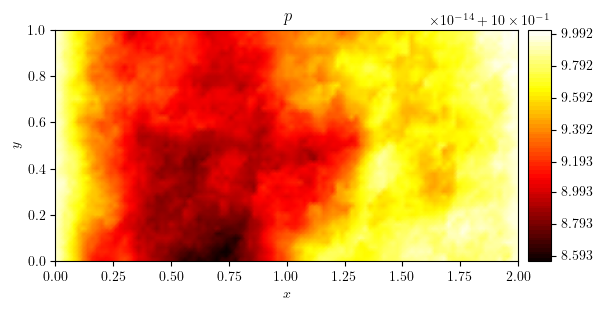

In [3]:
fig, ax = plot_colormap(p, title='p')
# plot_streamlines(fig, ax, u, color='hot')

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '$K$'}, xlabel='$x$', ylabel='$y$'>)

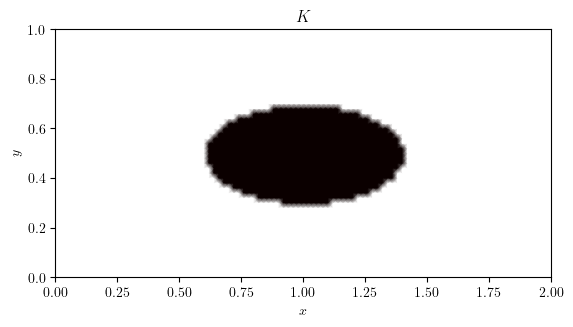

In [8]:
plot_colormap(k, title='K', colorbar=False)